20230910

In [1]:
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
from tqdm.notebook import tqdm


In [2]:
df = pd.read_csv("Data Scientist - task for interview.csv",
           encoding='unicode_escape')
df['Date'] = pd.TimedeltaIndex(df['Date'].astype(int), unit='d') + datetime.datetime(1899, 12, 30)
df.columns = df.columns.str.lower()
df.columns = [x.replace(' ','_') if ' ' in x else x for x in df.columns]
df['cost'] = df['qty']*df['value']
df['quarter'] = df['date'].dt.to_period('Q')
df['month'] = df['date'].dt.month
df.columns

Index(['date', 'store', 'product_name', 'qty', 'value', 'quality_of_presence',
       'cost', 'quarter', 'month'],
      dtype='object')

#### Min, max date 

In [3]:
df.head()

date store product_name  qty      value  quality_of_presence  \
0 2022-05-14     A     Áàòîí÷èê    1   8.270429                    4   
1 2022-05-14     B     Áàòîí÷èê    3  22.878811                    5   
2 2022-07-07     C     Áàòîí÷èê    9  63.083516                    6   
3 2022-07-07     D     Áàòîí÷èê    5  37.067506                    4   
4 2022-07-07     E     Áàòîí÷èê    9  63.620516                    7   

         cost quarter  month  
0    8.270429  2022Q2      5  
1   68.636433  2022Q2      5  
2  567.751645  2022Q3      7  
3  185.337530  2022Q3      7  
4  572.584640  2022Q3      7

In [4]:
df['date'].min(), df['date'].max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2022-12-31 00:00:00'))

#### value histogram in all df

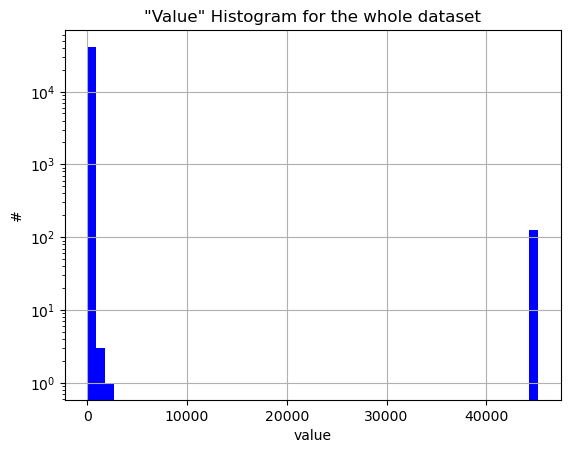

In [5]:
plt.hist(df['value'],bins=50,color='b', log=True);
plt.title('"Value" Histogram for the whole dataset')
plt.grid()
plt.ylabel("#")
plt.xlabel("value")
plt.show()

#### Show stores with more than 4 occerences of value > 40 000

In [6]:
s = 0
for store in df['store'].unique():
    df_store = df.query("store == @store and value > 350")
    df_store = df_store.sort_values(by='date')
    s += df_store.shape[0]
    if not df_store.empty and df_store.shape[0] > 4:
        print(store, df_store.shape[0])
        # display(df_store)
    # break
s

X 6
AU 9
DU 33
DBM 5


142

#### we won't lose much if clip values > 350:

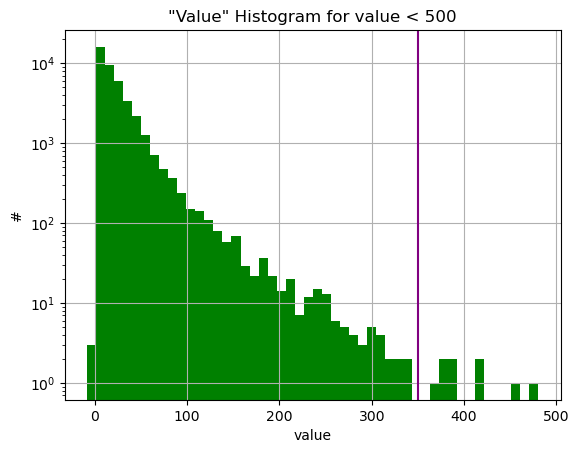

In [7]:
plt.hist(df.query('value < 500')['value'],bins=50,color='green', log=True);
plt.title('"Value" Histogram for value < 500')
plt.grid()
plt.ylabel("#")
plt.xlabel("value")
plt.axvline(350, color='purple')
plt.show()

In [8]:
df = df.query('value < 350')

#### Don't take into consideration stores with less than 101 rows

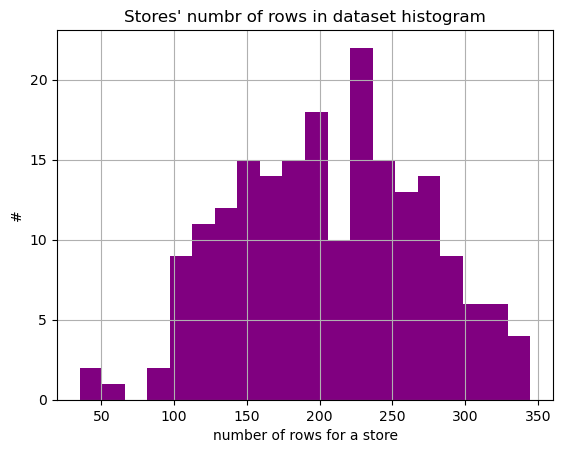

In [9]:
s = 0
sh = []
for store in df['store'].unique():
    df_store = df.query("store == @store")
    df_store = df_store.sort_values(by='date')
    if not df_store.empty:
        sh.append(df_store.shape[0])
plt.hist(sh, color='purple', bins = 20);
plt.title("Stores' numbr of rows in dataset histogram")
plt.xlabel("number of rows for a store")
plt.ylabel("#")
plt.grid()
plt.show()

In [10]:
df.groupby('store')['date'].agg(['count']).query("count > 100").sum()

count    40413
dtype: int64

In [11]:
40413 / df.shape[0]

0.9876099706744869

In [12]:
idx = df.groupby('store')['date'].agg(['count']).query("count < 101").index
#filter stores where rows count is < 101
df = df.query("not store.isin(@idx)")


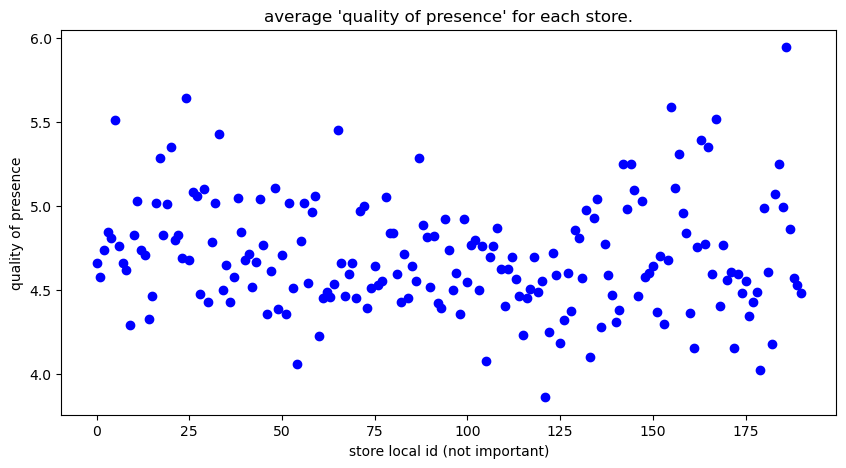

In [13]:
tmp = df.groupby('store')['quality_of_presence'].agg(['mean'])
plt.figure(figsize=(10,5))
plt.scatter(range(tmp.index.shape[0]), tmp['mean'], color='b')
plt.title("average 'quality of presence' for each store.")
plt.xlabel("store local id (not important)")
plt.ylabel("quality of presence")
plt.show()

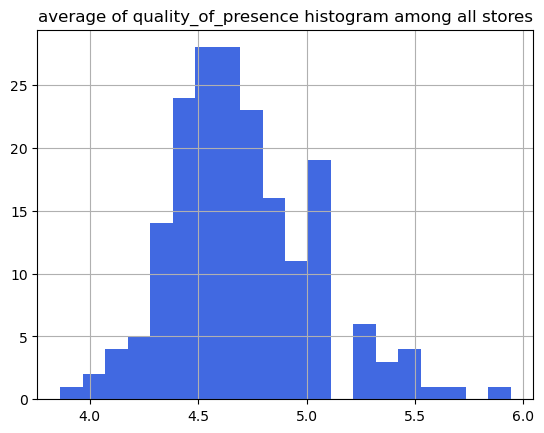

In [14]:
tmp = df.groupby('store')['quality_of_presence'].agg('mean')
plt.title("average of quality_of_presence histogram among all stores")
plt.hist(tmp, bins=20, color='royalblue');
plt.grid()
plt.show()


In [15]:
#average cheque by month among all stores
df.groupby('month')['cost'].agg(['mean'])


mean
month            
1       53.961982
2       64.350803
3      108.004699
4       69.477389
5       67.141752
6       60.568291
7      142.942766
8      173.498399
9      386.525125
10      77.498157
11      56.302426
12     417.249970

#### Spitting 1. Take 30% of stores as test, others are control. Among all data. 

In [16]:
%%time

sample_aver_dict = dict() 
sample_std_dict = dict()
sample_dict_one = dict()
store_lst = df['store'].unique()

for pct in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
    sample_aver, sample_std = [], []

    for _ in tqdm(range(10000)):
        stores_test = np.random.choice(store_lst, size=int(pct * len(store_lst)))
        # stores_contr = np.array(list(set(lst).difference(stores_test)))
        df_test = df.query("store.isin(@stores_test)")
        # df_contr = df.query("store.isin(@stores_contr)")
        sample_aver.append(df_test['cost'].mean())
        sample_std.append(df_test['cost'].std())
        sample_aver_dict[pct] = sample_aver
        sample_std_dict[pct] = sample_std
        sample_dict_one[pct] = df_test['cost']

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 5min 24s, sys: 13.3 s, total: 5min 37s
Wall time: 15min 39s


cost_mean whole dataset = 155.34. cost_mean sample = 152.07. Δ = 3.27
cost_std whole dataset = 557.87. cost_std sample = 513.76. Δ = 44.11


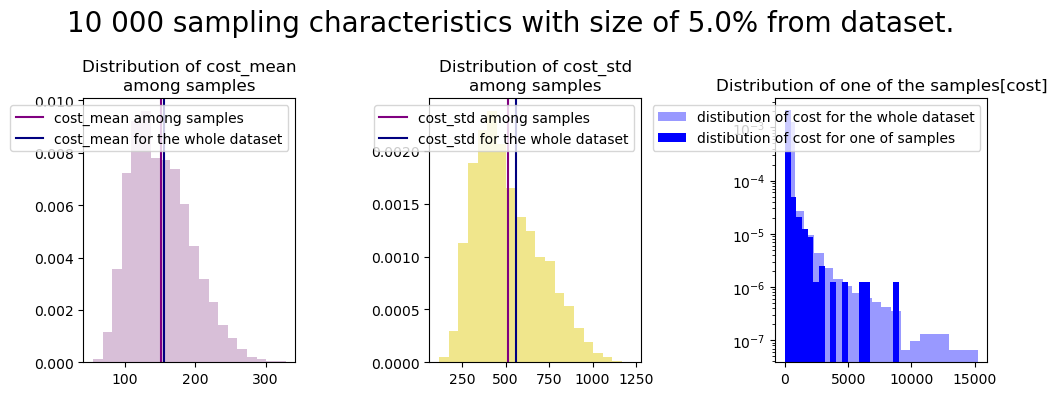

cost_mean whole dataset = 155.34. cost_mean sample = 154.03. Δ = 1.31
cost_std whole dataset = 557.87. cost_std sample = 536.19. Δ = 21.68


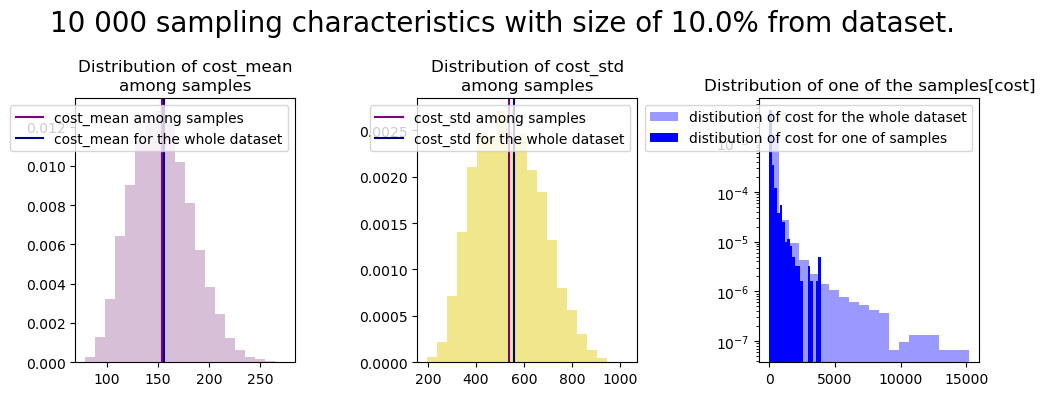

cost_mean whole dataset = 155.34. cost_mean sample = 154.68. Δ = 0.66
cost_std whole dataset = 557.87. cost_std sample = 546.21. Δ = 11.66


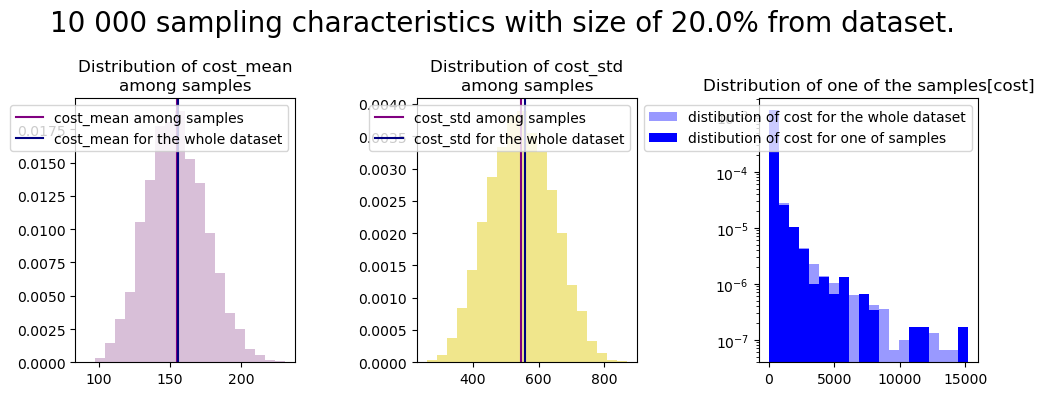

cost_mean whole dataset = 155.34. cost_mean sample = 155.15. Δ = 0.19
cost_std whole dataset = 557.87. cost_std sample = 552.54. Δ = 5.33


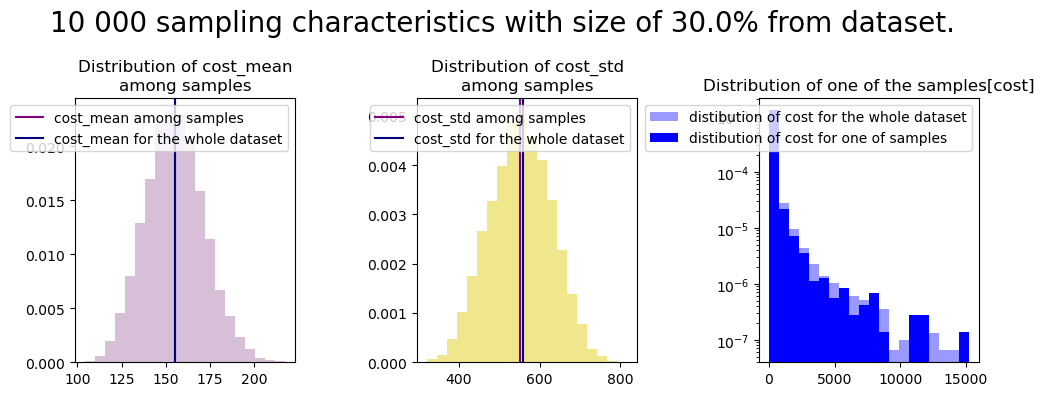

cost_mean whole dataset = 155.34. cost_mean sample = 154.99. Δ = 0.35
cost_std whole dataset = 557.87. cost_std sample = 552.99. Δ = 4.88


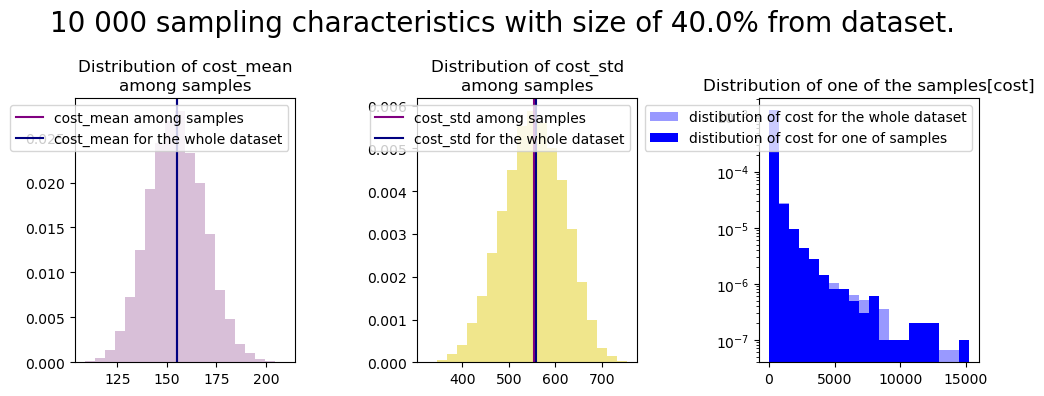

cost_mean whole dataset = 155.34. cost_mean sample = 155.26. Δ = 0.08
cost_std whole dataset = 557.87. cost_std sample = 554.78. Δ = 3.09


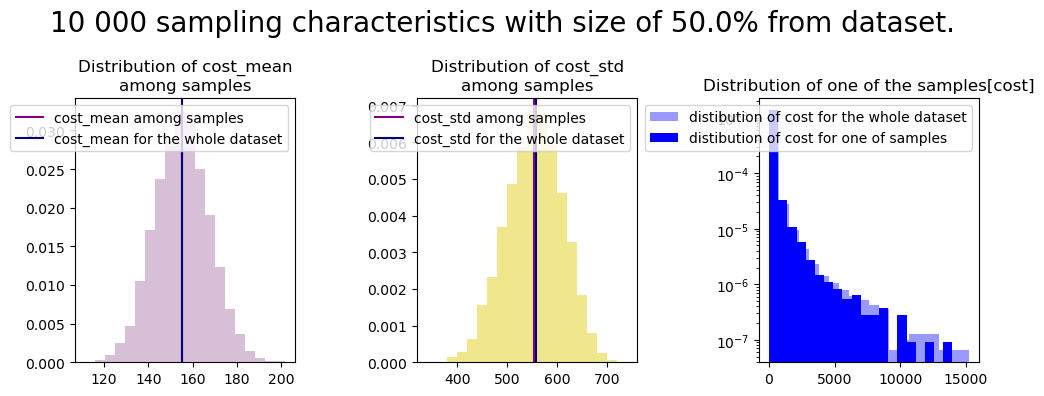

In [37]:
for pct in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
    fig, ax = plt.subplots(1, 3, figsize=(10,4))
    print(f"cost_mean whole dataset = {round(df['cost'].mean(),2)}", end=". ")
    print(f"cost_mean sample = {round(np.mean(sample_aver_dict[pct]),2)}",end=". ")
    print(f"Δ = {round(abs(df['cost'].mean() - np.mean(sample_aver_dict[pct])), 2)}")
    print(f"cost_std whole dataset = {round(df['cost'].std(),2)}", end=". ")
    print(f"cost_std sample = {round(np.mean(sample_std_dict[pct]),2)}", end=". ")
    print(f"Δ = {round(abs(df['cost'].std() - np.mean(sample_std_dict[pct])), 2)}")
    fig.suptitle(f'10 000 sampling characteristics with size of {100 * pct}% from dataset.', fontsize=20)

    ax[0].hist(sample_aver_dict[pct], color='thistle', bins=20, density=True);
    ax[0].set_title(f"Distribution of cost_mean\namong samples")
    ax[0].axvline(np.mean(sample_aver_dict[pct]), color='purple', label="cost_mean among samples")
    ax[0].axvline(df['cost'].mean(), color='navy', label="cost_mean for the whole dataset")
    ax[0].legend()
    
    ax[1].set_title(f"Distribution of cost_std\namong samples")
    ax[1].hist(sample_std_dict[pct], color='khaki', bins=20, density=True);
    ax[1].axvline(np.mean(sample_std_dict[pct]), color='purple', label="cost_std among samples")
    ax[1].axvline(df['cost'].std(), color='navy', label="cost_std for the whole dataset")
    ax[1].legend()

    ax[2].set_title(f"Distribution of one of the samples[cost]")
    ax[2].hist(df['cost'], color='b', bins=20, density=True, alpha=0.4, log=True, label="distibution of cost for the whole dataset");
    ax[2].hist(sample_dict_one[pct], color='b', bins=20, density=True, log=True, label="distibution of cost for one of samples");
    ax[2].legend()
    
    
    plt.tight_layout()
    plt.show()


#### Splitting 2. Since datasets related to each store are not large, and don't possess statistical continuity, put stores into buckets and buckets into control/test. For example, each store randomly goes to one of the 10 buckets and them 3 of them randomly go to test sampling. The other 7 consist control group.

In [ ]:
from collections import defaultdict

In [ ]:
buckets = defaultdict(list)
for store in df['store'].unique():
    t = np.random.choice(10)
    buckets[t].append(store)

In [ ]:
print("bucket #,  count of stores in bucket")
for b in buckets:
    print("      ", b, "      ", len(buckets[b]))
# sum(list(map(len, buckets.values())))

In [ ]:
buckets_test = np.random.choice(range(10), size=3, replace=False)
stores_test = []
for b in buckets_test:
    stores_test.extend(buckets[b])
    
buckets_contr = set(range(10)).difference(set(buckets_test))
stores_contr = []
for b in buckets_contr:
    stores_contr.extend(buckets[b])

assert len(stores_test) + len(stores_contr) == len(df['store'].unique())

In [ ]:
df_test = df.query("store.isin(@stores_test)")
df_contr = df.query("store.isin(@stores_contr)")

In [ ]:
df_contr['cost'].mean(), df_contr['cost'].std()

In [ ]:
df_test['cost'].mean(), df_test['cost'].std()

# Draft

#### Take 8 months and compare average cheque for some stores

In [ ]:

plt.hist(df_8mnth['cost'], bins=40, log=True);

In [ ]:
df_8mnth = df.query("month.isin([1,2,3,4,5,6,7,8])")
df_8mnth_A = df_8mnth.query("store == 'A'")
df_8mnth_B = df_8mnth.query("store == 'B'")
df_8mnth_A['cost'].mean(), df_8mnth_B['cost'].mean()
# plt.hist(df_8mnth_A['cost'], bins=20, alpha=0.5);
# plt.hist(df_8mnth_B['cost'], bins=20, alpha=0.5);

# plt.hist(df_8mnth['cost'], bins=30)


#### Let's look 4 months, and 2 weeks as pilot

#### don't fix stores in each group

In [ ]:
before_pilot = df.query("month.isin([1,2,3,4])")
# contr['cost']
res = []
cntr = 0
iters = 10000
for _ in tqdm(range(iters)):
    contr = before_pilot.sample(frac=0.3)
    test = before_pilot.drop(contr.index).sample(frac=0.2)
    tt = ttest_ind(contr['cost'], test['cost'], equal_var=False)
    if tt.pvalue < 0.05:
        # res.append(tt.pvalue)
        cntr += 1
        # print(_)
print(cntr/iters)

#### fix stores in each group

In [ ]:
#take 4 months before pilot and 1 month for testing
before_period_months = [1,2,3,4,5,6,7]
after_period_months = [8]


before_pilot = df.query("month.isin(@before_period_months)")
before_pilot_test = before_pilot.sample(frac=0.3).copy()
before_pilot_contr = before_pilot.drop(before_pilot_test.index).sample(frac=1.0).copy()
print(before_pilot_test.shape, before_pilot_contr.shape)

after_pilot = df.query("month.isin(@after_period_months)")
after_pilot_test = after_pilot.sample(frac=0.3).copy()
after_pilot_contr = after_pilot.drop(after_pilot_test.index).sample(frac=1.0).copy()
print(after_pilot_test.shape, after_pilot_contr.shape)

In [ ]:
stores_mean_before = before_pilot_contr.groupby('store')['cost'].agg('mean')


In [ ]:
%%time
df_unbiased_before = dict()
df_unbiased_after = dict()

df_unbiased_before['contr'] = pd.DataFrame()
df_unbiased_before['test'] = pd.DataFrame()
df_unbiased_after['contr'] = pd.DataFrame()
df_unbiased_after['test'] = pd.DataFrame()

# df_unbiased_before_contr = 
# df_unbiased_after_contr = pd.DataFrame()

# df_unbiased_before_test = pd.DataFrame()
# df_unbiased_after_test = pd.DataFrame()

for store in before_pilot_contr['store'].unique():
    #extract mean for control group
    store_before_contr = before_pilot_contr.query("store == @store").copy().sort_values('date')
    store_after_contr = after_pilot_contr.query("store == @store").copy().sort_values('date')
    
    store_before_contr['cost'] = store_before_contr['cost'] - stores_mean_before[store]    
    store_after_contr['cost'] = store_after_contr['cost'] - stores_mean_before[store]    

    df_unbiased_before['contr'] = pd.concat([df_unbiased_before['contr'], 
                                             df_store_before[['date','store','cost']]], axis=0)    
    df_unbiased_after['contr'] = pd.concat([df_unbiased_after['contr'], 
                                             df_store_after[['date','store','cost']]], axis=0)    

    #extract mean for test group
    store_before_test = before_pilot_test.query("store == @store").copy().sort_values('date')
    store_after_test = after_pilot_test.query("store == @store").copy().sort_values('date')
    
    store_before_test['cost'] = store_before_test['cost'] - stores_mean_before[store]    
    store_after_test['cost'] = store_after_test['cost'] - stores_mean_before[store]    

    df_unbiased_before['test'] = pd.concat([df_unbiased_before['test'], 
                                            df_store_before[['date','store','cost']]], axis=0)    
    df_unbiased_after['test'] = pd.concat([df_unbiased_after['test'],
                                           df_store_after[['date','store','cost']]], axis=0)    


In [ ]:
plt.hist(df_unbiased_before_test['cost'], alpha=0.5, bins=20);
plt.hist(df_unbiased_after_test['cost'], alpha=0.5, bins=20);


In [ ]:
print(ttest_ind(df_unbiased_before_contr['cost'], df_unbiased_after_contr['cost'], equal_var=False))
print(ttest_ind(df_unbiased_before_test['cost'], df_unbiased_after_test['cost'], equal_var=False))
# plt.hist(df_unbiased_before['cost'])
# ['store'].unique()


In [ ]:
Ttest_indResult(statistic=16.927680021979924, pvalue=1.4554314070873847e-61)
Ttest_indResult(statistic=16.927680021979924, pvalue=1.4554314070873847e-61)

In [ ]:
# contr[['date','store','cost']]
for store in contr['store'].unique():
    df_store = contr.query("store == @store").copy()
    df_store['cost'] -= mean_stores_4mnth['A']
    pd.concat([df_cost, df_store[['date','store','cost']]], axis=1)


In [ ]:
df_store

In [ ]:
tt = ttest_ind(contr['cost'], test['cost'], equal_var=False)
tt.pvaluelue

In [ ]:
tmp = df.groupby(['store', 'month'])['value'].agg(['mean'])
tmp = tmp.reset_index()
tmp = pd.pivot_table(data=tmp, values=['mean'], columns=['store'], index='month')
tmp.columns = tmp.columns.get_level_values(1)
tmp.columns.name = None

tmp
# plt.hist(tmp.sum(axis=0))
# .groupby('quarter')['value'].agg(['mean'])
# tmp.index = [f"{x}_{y}" for x,y in tmp.index.to_flat_index()]



In [ ]:
msk = (df['date'] >= pd.Timestamp(2022,1,1)) & (df['date'] < pd.Timestamp(2022,2,1))
df_jan = df[msk].reset_index(drop=True)
for store in df_jan['store'].unique():
    df_jan_store = df_jan.query("store == @store")
    if df_jan_store.shape[0] < 15:
        continue
    print(store, df_jan_store.shape[0])
    break